# Counting shapes

Training times for this task are too long to do interactively, so they were done in batch using a Python scrip [`count_shapes.py`](count_shapes.py) and a PBS script [`count_shapes.pbs`](count_shapes.pbs).  Here, we analyse the results of that computation.

## Required modules

In [21]:
import itertools
from data_utils import process_data
from history_utils import plot_history_file
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline
import numpy as np

## History

The training history containing the loss and accuracty informatino as a function of the training epochs has been saved as a pickle file.

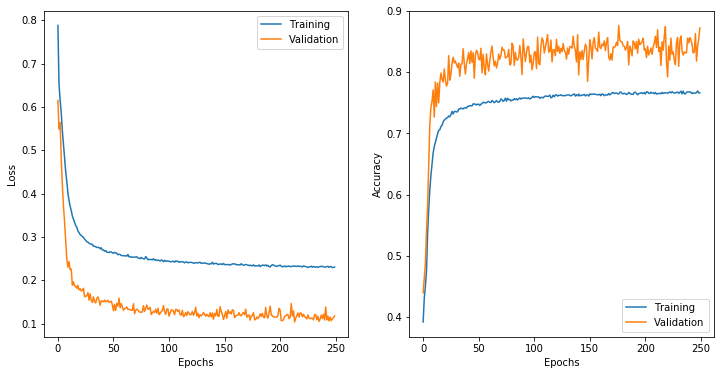

In [2]:
plot_history_file('count_shapes_hist.h5')

## Model

The model itself has been saved as an HDF5 file

In [2]:
model = load_model('count_shapes.h5')

We can load a small test set to evaluate performance and analyse network properties.

In [3]:
x_test, y_test = process_data('test_multi_obj_data.h5')

In [5]:
model.evaluate(x_test, y_test)

40000/40000 [==============================] - 324s 8ms/step


[0.1175849391579628, 0.871525]

## Analysis of results

To gain some insight in the weak points of the model, we can generate the predictions of the model on the test input, and compare that to the test output.

In [4]:
def predict(model, x_data):
    y_data = model.predict(x_data)
    return np.round(y_data).astype(np.int64)

In [7]:
y_counts = predict(model, x_test)

It is useful to visualize the input data, and the predicted versus the expected output. We define some helper functions for this purpose.

In [64]:
def generate_title(counts):
    names = ['c', 's', 't']
    strs = map(lambda x: f'{x[0]}: {x[1]:d}', zip(names, counts))
    return ', '.join(strs)

def display_results(x_data, y_data=None, y_pred=None, max_rows=5, max_cols=5):
    ncols = min(max_cols, x_data.shape[0])
    nrows = min(max_rows, 1 + x_data.shape[0]//ncols)
    if x_data.shape[0] % ncols == 0:
        nrows -= 1
    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    for index in range(nrows*ncols):
        if index < x_data.shape[0]:
            axes[index].imshow(x_data[index, ..., 0], cmap='gray')
            expected, predicted = '', ''
            if y_data is not None:
                expected = 'exp = ' + generate_title(y_data[index])
            if y_pred is not None:
                predicted = 'prd = ' + generate_title(y_pred[index])
            if y_data is not None or y_pred is not None:
                title = '\n'.join((expected, predicted))
                axes[index].set_title(title)
        axes[index].get_xaxis().set_visible(False)
        axes[index].get_yaxis().set_visible(False)
    figure.tight_layout()

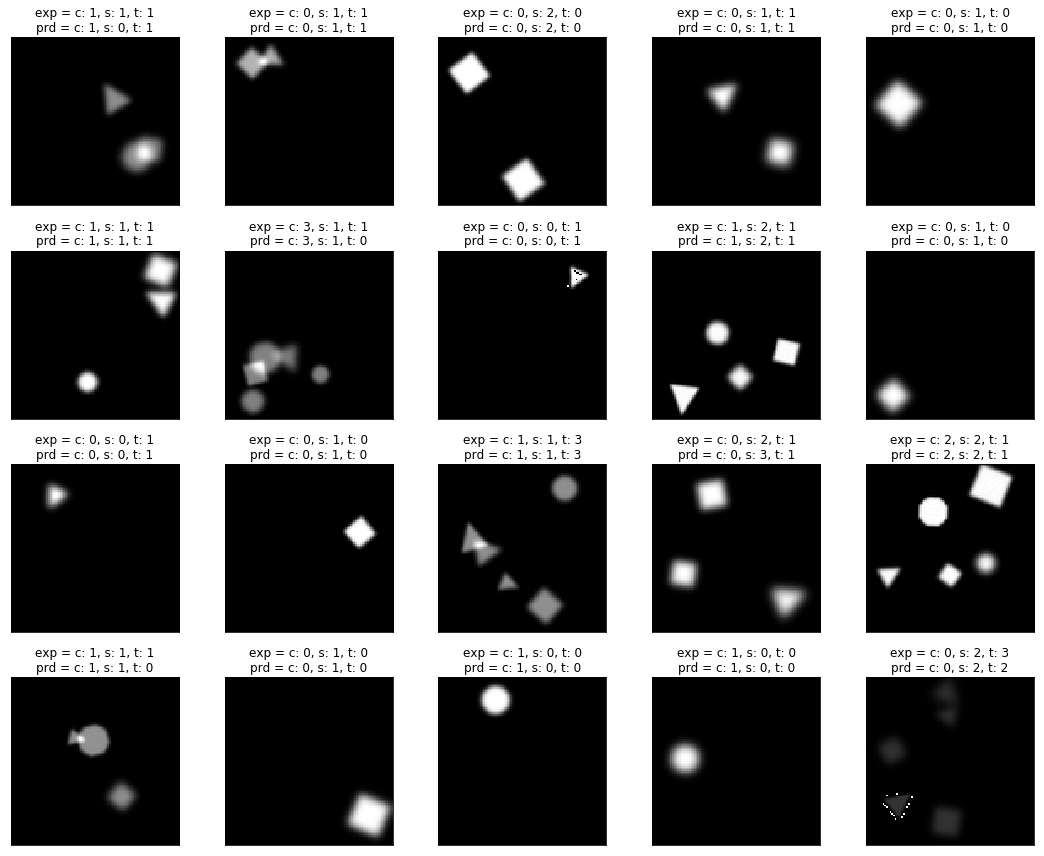

In [66]:
nr_data = 25
display_results(x_test[:nr_data], y_test[:nr_data], y_counts[:nr_data])

Apparently, the model is typically doing fairly well when shapes don't overlap.  Let's try to get some more details. The array `correct` will have `True` if the counts are correct, `False` otherwise.

In [8]:
correct = y_counts == y_test

Apparently, squares are hard to count correctly.

In [9]:
correct.mean(axis=0)

array([0.87385 , 0.842075, 0.881375])

The number of shapes to count also influences the results.  Fewer shapes are easy, more shapes get harder.  Of course, the probability that two or more shapes overlap increases with the number of shapes.

In [10]:
for nr_shapes in range(1, 6):
    fraction_correct = correct[(y_test.sum(axis=1) == nr_shapes)].all(axis=1).mean()
    print(f'{nr_shapes:d} shapes: {fraction_correct:.3f}')

1 shapes: 0.966
2 shapes: 0.869
3 shapes: 0.716
4 shapes: 0.573
5 shapes: 0.387


It is also interesting to get the accuracy split up by shape over the different total number of shapes.

In [11]:
max_nr_shapes = 5
nr_shape_types = 3
score_matrix = np.empty((max_nr_shapes, nr_shape_types))
for nr_shapes in range(1, max_nr_shapes + 1):
    score_matrix[nr_shapes - 1, :] = correct[(y_test.sum(axis=1) == nr_shapes)].mean(axis=0)
score_matrix

array([[0.983625  , 0.98175   , 0.994     ],
       [0.96690307, 0.92148812, 0.96142839],
       [0.88590519, 0.83850227, 0.90922844],
       [0.80921136, 0.7770347 , 0.82927445],
       [0.72464841, 0.6925734 , 0.71453245]])

In [26]:
def plot_matrix(matrix, row_tick_labels=None, col_tick_labels=None,
                row_label=None, col_label=None,
                normalize=False, cmap=plt.cm.Blues):
    figure, axes = plt.subplots(figsize=(6, 6))
    axes.imshow(matrix, interpolation='nearest', cmap=cmap)
    if col_tick_labels is not None:
        def format_fn(tick_val, tick_pos):
            if int(tick_val) in range(len(col_tick_labels)):
                return col_tick_labels[int(tick_val)]
            else:
                return ''
        axes.get_xaxis().set_major_formatter(FuncFormatter(format_fn))
        axes.get_xaxis().set_major_locator(MaxNLocator(integer=True))
    else:
        axes.get_xaxis().set_visible(False)
    if row_tick_labels is not None:
        def format_fn(tick_val, tick_pos):
            if int(tick_val) in range(len(row_tick_labels)):
                return row_tick_labels[int(tick_val)]
            else:
                return ''
        axes.get_yaxis().set_major_formatter(FuncFormatter(format_fn))
        axes.get_yaxis().set_major_locator(MaxNLocator(integer=True))
    else:
        axes.get_yaxis().set_visible(False)

    fmt = '{0:.3f}'
    thresh = (matrix.max() + matrix.min())/2.0
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        axes.text(j, i, fmt.format(matrix[i, j]),
                  horizontalalignment="center",
                  color="white" if matrix[i, j] > thresh else "black",
                  fontsize=8)

    figure.tight_layout()
    if row_label is not None:
        axes.set_ylabel(row_label)
    if col_label is not None:
        axes.set_xlabel(col_label)

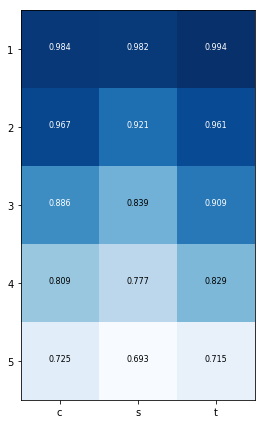

In [27]:
plot_matrix(score_matrix, row_tick_labels=['1', '2', '3', '4', '5'], col_tick_labels=['c', 's', 't'])

Apparently, squares are more difficult to identify that circles or triangles.